# Test Concepts

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

file_names = ['eps_12_r_10.out','eps_3_r_20.out', 'eps_12_r_10_bark.out', 'eps_3_r_20_bark.out', 'eps_12_r_10_bark_shifted.out']
Ez_list = []
bscan = 20

# Load the data from each file
for file_name in file_names:
    with h5py.File(file_name, 'r') as f:
        Ez = f['rxs']['rx1']['Ez'][()]
        Ez_list.append(Ez)

with h5py.File('src_only.out', 'r') as f0:
    Ez0 = f0['rxs']['rx1']['Ez'][()]
src = Ez0[:, 0]
src = src[:, np.newaxis]  # Add a new axis

Ez0 = np.repeat(src, bscan, axis=1)
# Compute the differences relative to the first file
Ez_diff_list = [np.subtract(Ez, Ez0) for Ez in Ez_list]

# Concatenate the arrays along the second axis
Ez = np.concatenate(Ez_diff_list, axis=1)

# Set the desired width and height of the figure
fig_width = 15
fig_height = 15

# Create the figure and axes objects with the desired size and aspect ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Generate the image
plt.imshow(Ez, cmap='seismic', aspect='auto')

# distances = []

# for column in range(Ez.shape[1]):
#     maxima = np.where((Ez[1:-1, column] > Ez[:-2, column]) & (Ez[1:-1, column] > Ez[2:, column]))[0] + 1
#     sorted_maxima = maxima[np.argsort(Ez[maxima, column])][-2:]  # Sort and select first 2 local maxima

#     if len(sorted_maxima) >= 2:
#         distance = abs(sorted_maxima[1] - sorted_maxima[0])  # Calculate distance between the two maxima
#         distances.append(distance)

# Display the plot
plt.show()


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'src_only.out', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

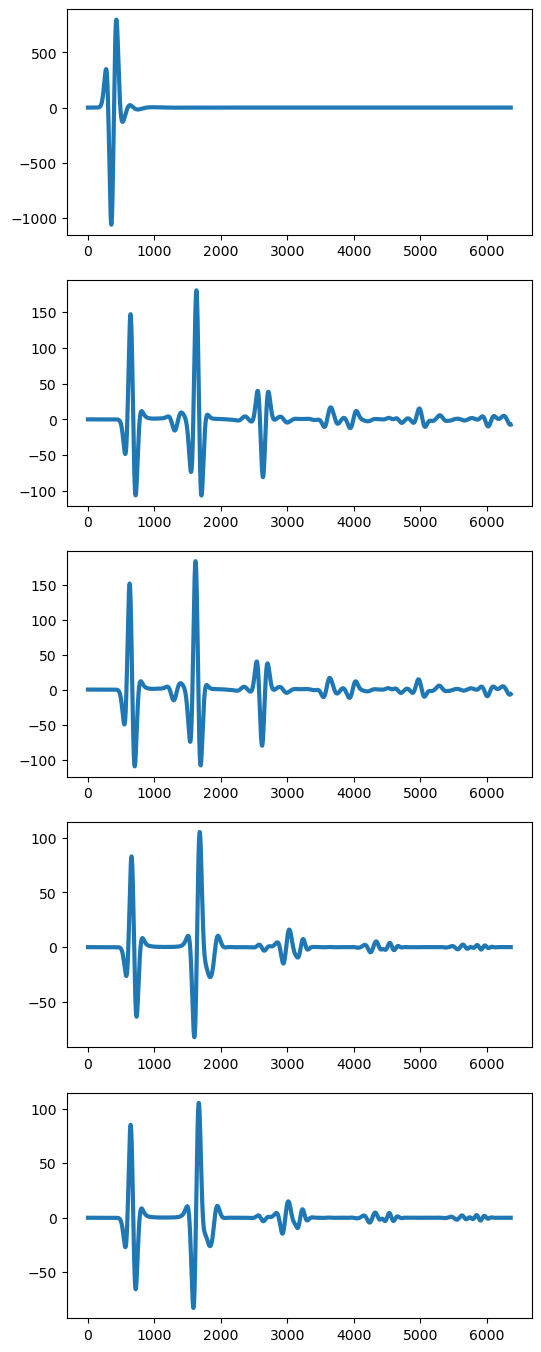

In [3]:
# Extract a single column (e.g., column 5)
signal_data_1 = Ez[:, 5]
signal_data_2 = Ez[:, 15]
signal_data_3 = Ez[:, 25]
signal_data_4 = Ez[:, 35]
# Plotting
fig, ax = plt.subplots(nrows=5, figsize=(6, 17))
ax[0].plot(src, label="original", lw=3)
ax[1].plot(signal_data_1, label="original", lw=3)
ax[2].plot(signal_data_2, label="filter", lw=3)
ax[3].plot(signal_data_3, label="original", lw=3)
ax[4].plot(signal_data_4, label="filter", lw=3)

plt.show()

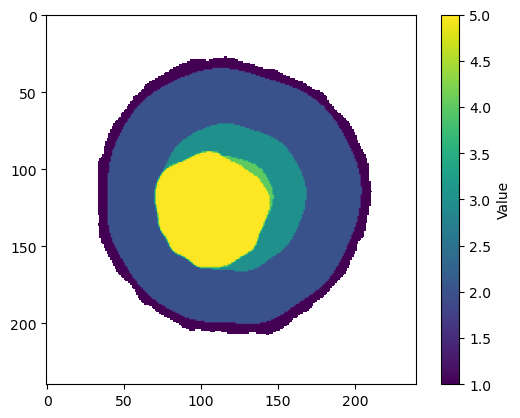

In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma

f = h5py.File('cavity_1.h5', 'r')
data = f['data']

# Create a masked array where 0 values are masked (transparent)
masked_data = ma.masked_equal(data[:, :, 15], 0)

# Generate the image
plt.imshow(masked_data, cmap='viridis')

# Add a colorbar legend
cbar = plt.colorbar()
cbar.set_label('Value')

# Display the plot
plt.show()
f.close()

## Shape Generation and Bscan approximation

In [55]:
import math
import random
def generate_random_convex_polygon(n):
    x_pool = [random.random() for _ in range(n)]
    y_pool = [random.random() for _ in range(n)]

    x_pool.sort()
    y_pool.sort()

    min_x = x_pool[0]
    max_x = x_pool[n - 1]
    min_y = y_pool[0]
    max_y = y_pool[n - 1]

    x_vec = []
    y_vec = []
    last_top = min_x
    last_bot = min_x

    for i in range(1, n - 1):
        x = x_pool[i]

        if random.choice([True, False]):
            x_vec.append(x - last_top)
            last_top = x
        else:
            x_vec.append(last_bot - x)
            last_bot = x

    x_vec.append(max_x - last_top)
    x_vec.append(last_bot - max_x)

    last_left = min_y
    last_right = min_y

    for i in range(1, n - 1):
        y = y_pool[i]

        if random.choice([True, False]):
            y_vec.append(y - last_left)
            last_left = y
        else:
            y_vec.append(last_right - y)
            last_right = y

    y_vec.append(max_y - last_left)
    y_vec.append(last_right - max_y)

    random.shuffle(y_vec)

    vec = [Point2D(x, y) for x, y in zip(x_vec, y_vec)]

    vec.sort(key=lambda v: math.atan2(v.y, v.x))

    x = 0
    y = 0
    min_polygon_x = 0
    min_polygon_y = 0
    points = []

    for i in range(n):
        points.append(Point2D(x, y))

        x += vec[i].x
        y += vec[i].y

        min_polygon_x = min(min_polygon_x, x)
        min_polygon_y = min(min_polygon_y, y)

    x_shift = min_x - min_polygon_x
    y_shift = min_y - min_polygon_y

    for i in range(n):
        p = points[i]
        points[i] = Point2D(p.x + x_shift, p.y + y_shift)

    return points

class Point2D:
    def __init__(self, x, y):
        self.x = x
        self.y = y


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

def find_boundary_points(arr):
    # Identify the boundary positions
    boundary_mask = np.zeros_like(arr, dtype=bool)
    boundary_mask[1:-1, 1:-1] = ((
        (arr[1:-1, :-2] == 0)
        | (arr[1:-1, 2:] == 0)
        | (arr[:-2, 1:-1] == 0)
        | (arr[2:, 1:-1] == 0))
        & (arr[1:-1, 1:-1] == 1)
    )

    # Extract the boundary positions as (x, y) coordinates
    boundary_points = np.column_stack(np.where(boundary_mask))

    return boundary_points

def make_boundary_zero(arr):
    boundary_points = find_boundary_points(arr)
    arr[boundary_points[:, 0], boundary_points[:, 1]] = 0
    return arr

def make_non_boundary_zero(arr):
    boundary_points = find_boundary_points(arr)
    arr = np.zeros_like(arr)
    arr[boundary_points[:, 0], boundary_points[:, 1]] = 1
    return arr

def find_closest_point(points_array, x, y):
    distances = np.sqrt(np.sum((points_array - np.array([x,y]))**2, axis=1))
    index = np.argmin(distances)
    return points_array[index]

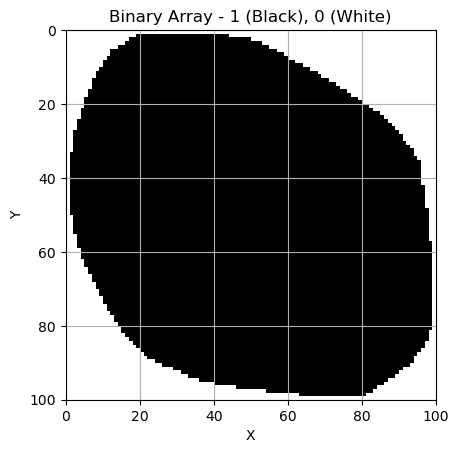

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath

# Set the resolution of the binary array
resolution = 100  # Adjust as needed for desired resolution

# Generate the convex polygon points
n = 50  # Number of points
points = generate_random_convex_polygon(n)

# Extract x and y coordinates
x_coords = [point.x for point in points]
y_coords = [point.y for point in points]

# Create a matplotlib Path object from the polygon points
polygon_path = mpath.Path(np.column_stack((x_coords, y_coords)))

# Define the bounding box to encompass the polygon
x_min, x_max = min(x_coords), max(x_coords)
y_min, y_max = min(y_coords), max(y_coords)


# Generate the binary array representing the polygon
x_vals = np.linspace(x_min, x_max, resolution)
y_vals = np.linspace(y_min, y_max, resolution)

outline_array = np.zeros((resolution, resolution), dtype=int)

for i, y in enumerate(y_vals):
    for j, x in enumerate(x_vals):
        if polygon_path.contains_point((x, y)):
            outline_array[i, j] += 1

# Plot the binary array
plt.imshow(outline_array, cmap='binary', origin='lower', vmin=0, vmax=1, extent=[0, outline_array.shape[1], outline_array.shape[0], 0])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Binary Array - 1 (Black), 0 (White)')
plt.grid(True)
plt.show()


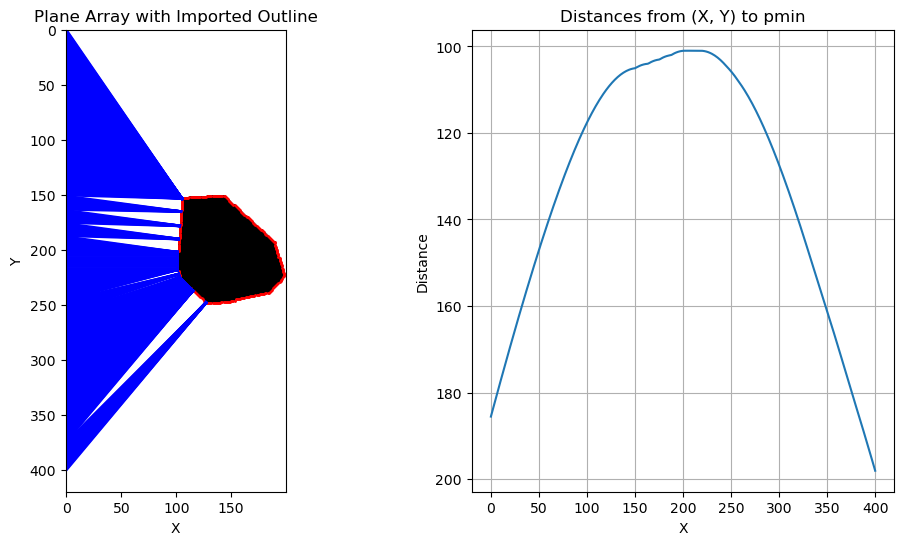

In [58]:
# Define the size of the plane_array
plane_width = 200
plane_height = 400
y_src = 0

# Define the starting position of the outline_array in the plane_array
start_x = 100
start_y = int((plane_height-resolution)/2)


# Create the plane_array
plane_array = np.zeros((plane_height, plane_width), dtype=int)

# Calculate the ending positions of the outline_array
end_x = start_x + outline_array.shape[1]
end_y = start_y + outline_array.shape[0]

# Import the outline_array into the plane_array
plane_array[start_y:end_y, start_x:end_x] = outline_array

# Find boundary points
boundary_points = find_boundary_points(plane_array)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the plane_array
ax1.imshow(plane_array, cmap='binary', origin='lower', vmin=0, vmax=1)
ax1.invert_yaxis()
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Plane Array with Imported Outline')
# Scatter plot the boundary_points
ax1.scatter(boundary_points[:, 1], boundary_points[:, 0], c='red', marker='o', s=1, label='Boundary Points')

distances = []

for x in range(plane_height + 1):
    pmin = find_closest_point(boundary_points, x, y_src)
    ax1.plot([y_src, pmin[1]], [x, pmin[0]], 'b-', linewidth=2)
    
    # Calculate the distance between (x, y_src) and pmin
    distance = np.sqrt((x - pmin[0]) ** 2 + (y_src - pmin[1]) ** 2)
    distances.append(distance)

# Plot the distances on ax2
ax2.plot(range(plane_height + 1), distances)
ax2.set_xlabel('X')
ax2.set_ylabel('Distance')
ax2.invert_yaxis()
ax2.set_title('Distances from (X, Y) to pmin')
ax2.grid(True)





In [59]:
import h5py
import numpy as np
import os

# Define the base filename
base_filename = "generated_geometry.h5"

# Check if the file already exists
suffix = 1
filename = base_filename
while os.path.exists(filename):
    suffix += 1
    filename = f"{base_filename.split('.h5')[0]}{suffix}.h5"
cavity_array = np.where(outline_array == 1, 8, -1)
# Create a new HDF5 file
arr_3d = np.expand_dims(cavity_array, axis=2)
# Create a dataset within the 'data' group and store the array
with h5py.File(filename, 'w') as file:
    dset = file.create_dataset("data", data=arr_3d)

    # Add a root attribute with the name 'dx_dy_dz'
    file.attrs['dx_dy_dz'] = (0.002, 0.002, 0.002)



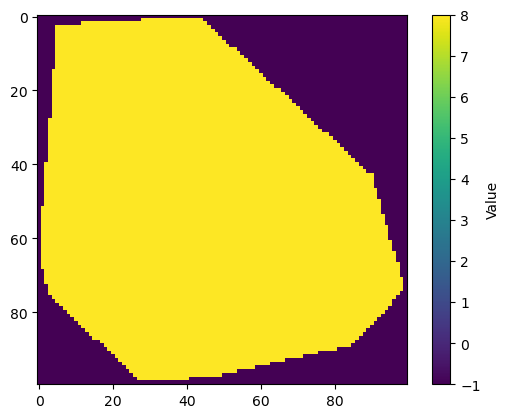

In [60]:
with h5py.File(filename, 'r') as f:
    dt = f['data'][()]

# Generate the image
plt.imshow(dt, cmap='viridis')

# Add a colorbar legend
cbar = plt.colorbar()
cbar.set_label('Value')

# Display the image
plt.show()
f.close()

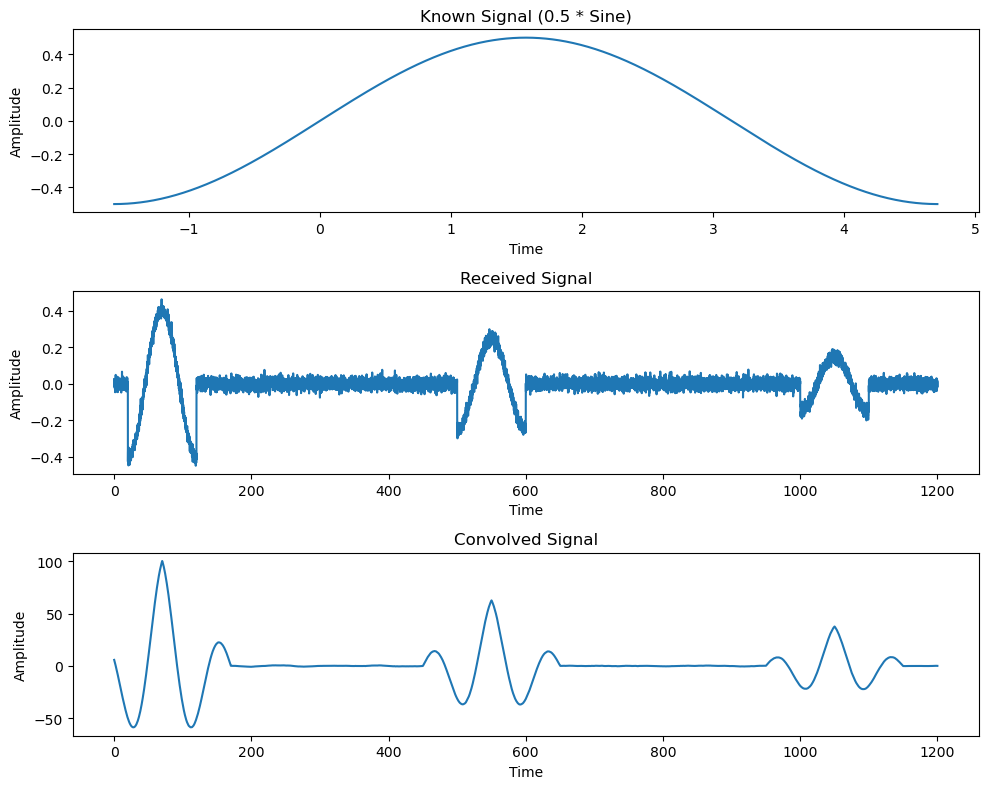

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define the known signal (0.5 times a sine function)
t_known = np.linspace(-0.5*np.pi, 1.5*np.pi, 1000)
known_signal = 0.5 * np.sin(t_known)

# Generate a received signal with observed pulses, varying strengths, and noise
t_received = np.linspace(0, 1200, 12000)
received_signal = np.random.normal(0, 0.02, len(t_received))  # Add random noise
received_signal[200:200+len(t_known)] += 0.8 * known_signal  # Varying strength
received_signal[5000:5000+len(t_known)] += 0.5 * known_signal
received_signal[10000:10000+len(t_known)] += 0.3 * known_signal

# Perform the convolution
convolved_signal = np.convolve(received_signal, known_signal, mode='same')

# Plotting the signals
plt.figure(figsize=(10, 8))

# Known signal
plt.subplot(3, 1, 1)
plt.plot(t_known, known_signal)
plt.title('Known Signal (0.5 * Sine)')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Received signal
plt.subplot(3, 1, 2)
plt.plot(t_received, received_signal)
plt.title('Received Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Convolved signal
plt.subplot(3, 1, 3)
plt.plot(t_received, convolved_signal)
plt.title('Convolved Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


C:\Users\thanh\AppData\Local\Temp\ipykernel_6616\3524249777.py:54: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(mean_values, compressed_signal[mean_values], 'r', use_line_collection=True)


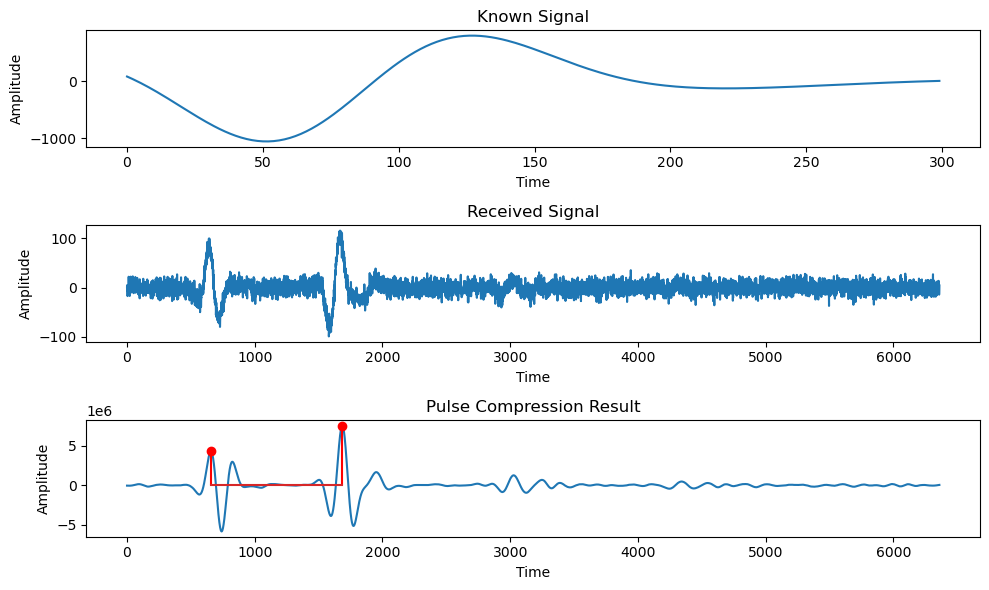

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define the known signal and received signal
known_signal = np.array(src[300:600]).flatten()  # Convert known signal to a 1D array
received_signal = np.array(signal_data_4).flatten()  # Convert received signal to a 1D array

# Add random noise to the signal
noise_amplitude = 10  # Adjust the amplitude of the noise
noise = np.random.normal(0, noise_amplitude, received_signal.shape)
received_signal = received_signal + noise

# Perform pulse compression
compressed_signal = np.convolve(received_signal, known_signal[::-1], mode='same')

# Define the threshold fraction for peak detection
threshold_fraction = 0.5  # Adjust this value as needed

# Calculate the threshold for peak detection
threshold = threshold_fraction * np.max(compressed_signal)

# Find the locations of impulse functions (peaks) in the compressed signal
impulse_indices = np.where(compressed_signal >= threshold)[0]
# Find the indices where clusters start
cluster_indices = np.where(np.diff(impulse_indices) != 1)[0] + 1

# Split the array into clusters
clusters = np.split(impulse_indices, cluster_indices)

# Calculate the mean value for each cluster
mean_values = np.array([np.mean(cluster) for cluster in clusters])
mean_values = mean_values.astype(int)

# Plotting the signals
plt.figure(figsize=(10, 6))

# Plot the known signal
plt.subplot(3, 1, 1)
plt.plot(known_signal)
plt.title('Known Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot the received signal
plt.subplot(3, 1, 2)
plt.plot(received_signal)
plt.title('Received Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot the pulse compression result
plt.subplot(3, 1, 3)
plt.plot(compressed_signal)
plt.stem(mean_values, compressed_signal[mean_values], 'r', use_line_collection=True)
plt.title('Pulse Compression Result')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


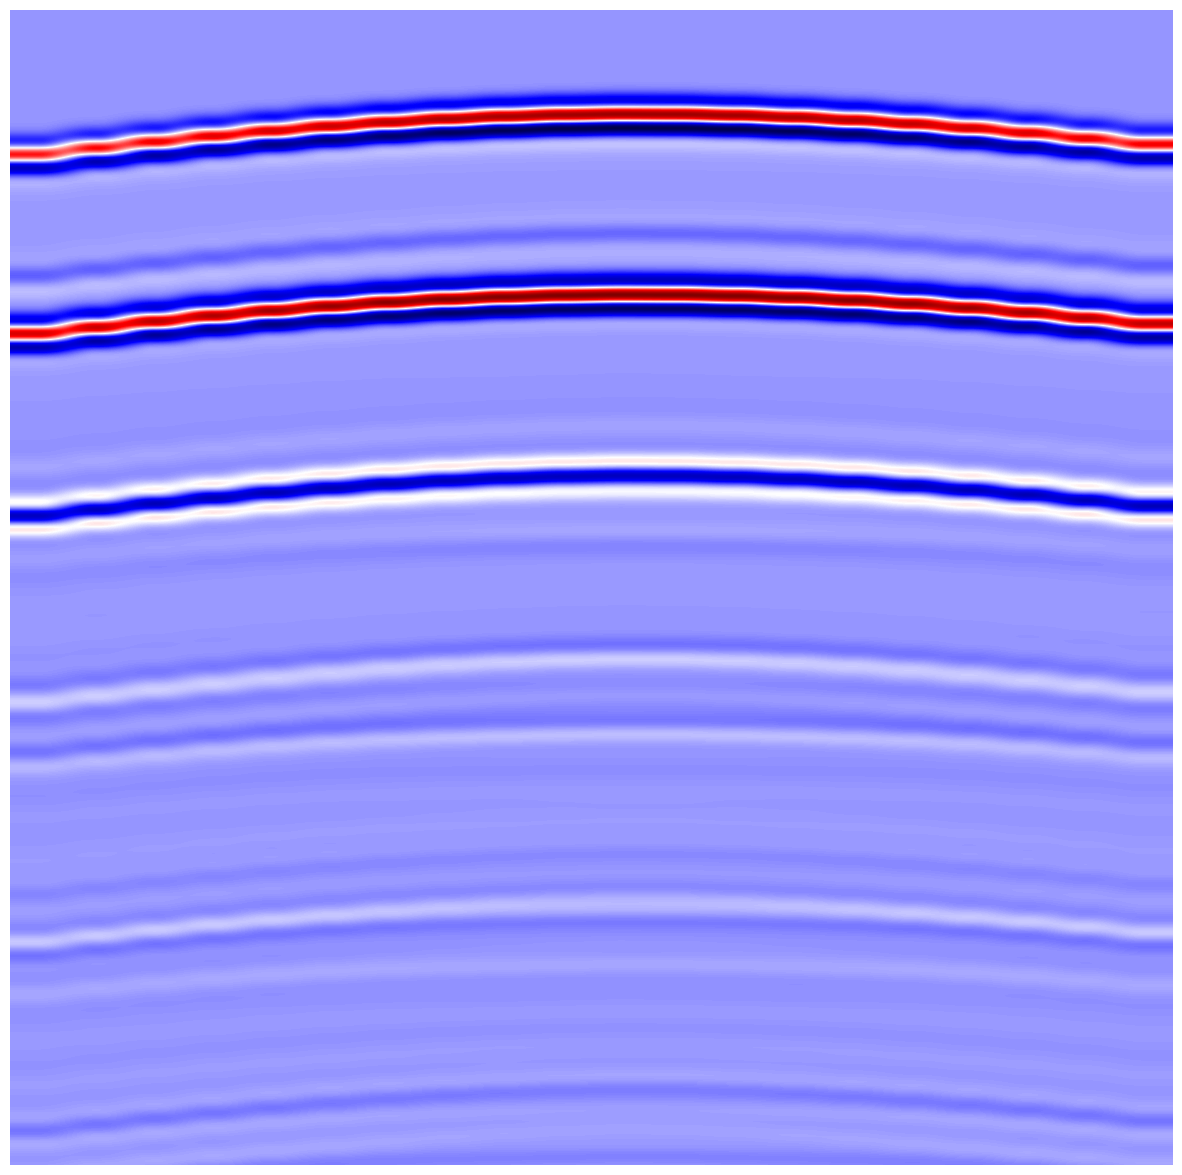

In [27]:
import cv2
import numpy as np

import h5py
import numpy as np
import matplotlib.pyplot as plt

file_name = 'eps_12_r_10.out'

# Load the data from each file
with h5py.File(file_name, 'r') as f:
    Ez1 = f['rxs']['rx1']['Ez'][()]
       
with h5py.File('src_only.out', 'r') as f0:
    Ez0 = f0['rxs']['rx1']['Ez'][()]

src = Ez0[:, 0]
src = src[:, np.newaxis]  # Add a new axis

Ez0 = np.repeat(src, 20, axis=1)
# Compute the differences relative to the first file
Ez1_norm = np.subtract(Ez1, Ez0)

# Set the desired width and height of the figure
fig_width = 15
fig_height = 15

# Create the figure and axes objects with the desired size and aspect ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Generate the image
plt.imshow(Ez1_norm, cmap='seismic', aspect='auto')

# Remove axis values and labels
ax.axis('off')

# Save the plot as a PNG file
plt.savefig('plot.png', dpi=300, bbox_inches='tight', pad_inches=0)

# Display the plot
plt.show()


In [50]:
import cv2
import matplotlib.pyplot as plt

# Convert the image to grayscale
img = cv2.imread('plot.png')
resized = cv2.resize(img, (640,640), interpolation = cv2.INTER_AREA)
grayFrame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurredFrame = cv2.blur(grayFrame, (3, 3))
cannyFrame = cv2.Canny(blurredFrame, 50, 60, 5)
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
# dilatedFrame = cv2.dilate(cannyFrame, kernel)

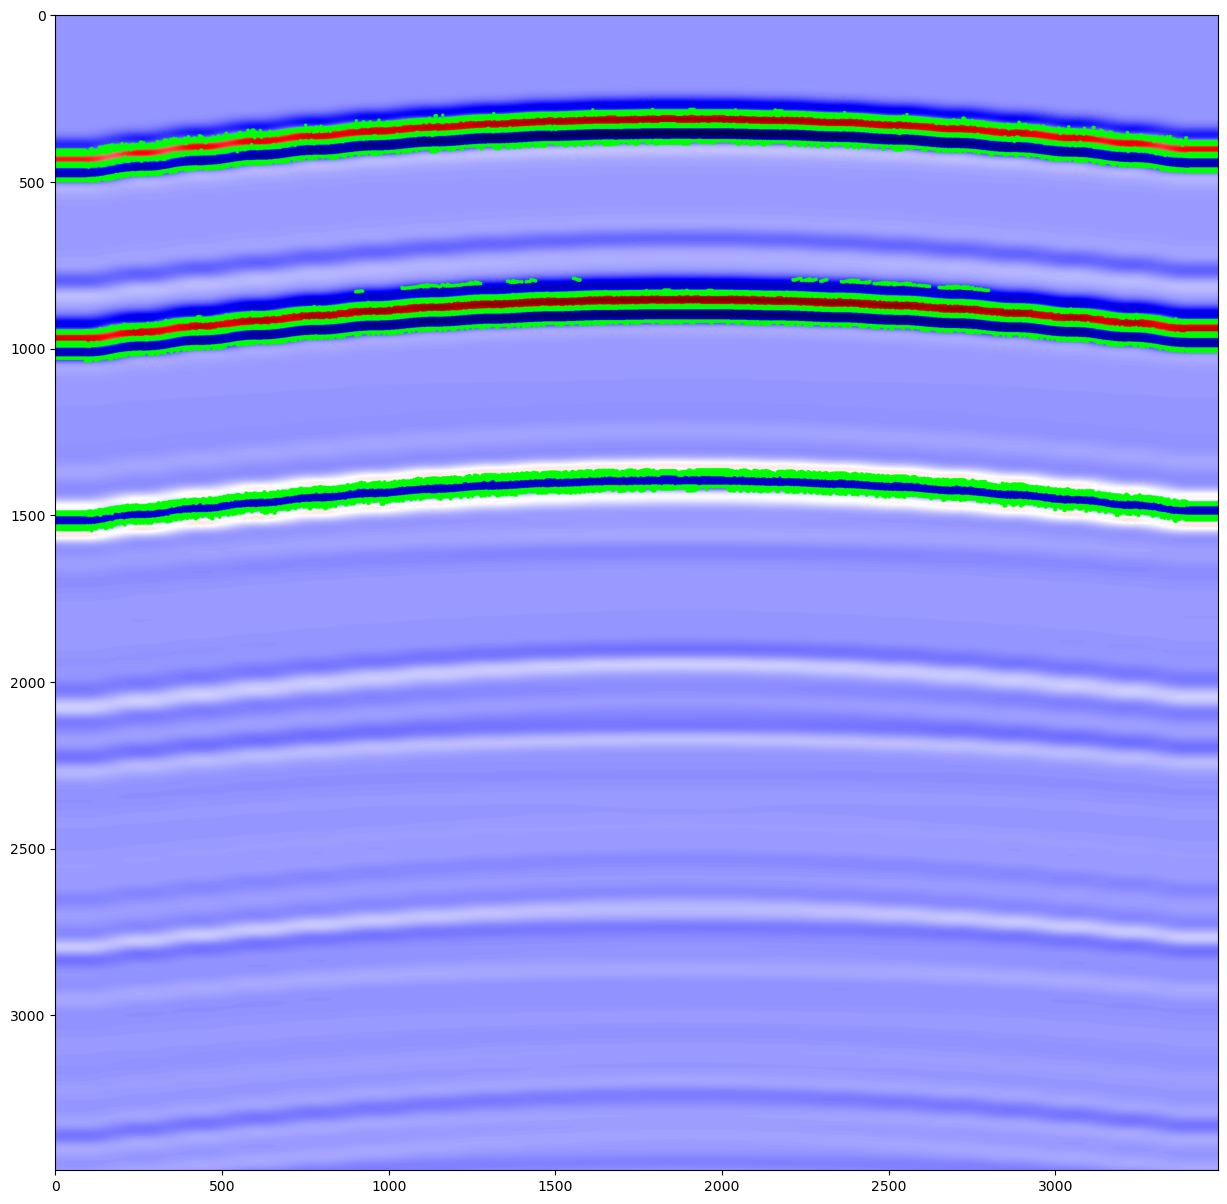

In [51]:
# Find contours in the Canny frame
contours, hierarchy = cv2.findContours(cannyFrame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contourFrame = cv2.drawContours(img, contours, -1, (0, 255, 0), 10)

# Set the desired width and height of the figure
fig_width = 15
fig_height = 15

# Create the figure and axes objects with the desired size and aspect ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
plt.imshow(cv2.cvtColor(contourFrame, cv2.COLOR_BGR2RGB))

plt.show()